## Load data

In [1]:
%load_ext autoreload
%autoreload

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from data_utils import get_training, get_testing, HEADER
from sklearn.linear_model import LogisticRegression

from validation import Validation
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from my_pca import my_pca

%matplotlib notebook


### LinearDiscriminantAnalysis - PCA

In [2]:
# Logistic Regression
X, y = get_training()
mdl = LinearDiscriminantAnalysis()
val = Validation(X, y, k = 10)
pca_comp = [3,5,9,11,13,15,20,25,30]

pca_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}
bsf = (0,-1)
for comp in pca_comp:
    val.update(pca=comp)
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    pca_results['accuracy'].append(np.array(r['accuracy']).mean())
    pca_results['recall'].append(np.array(r['recall']).mean())
    pca_results['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, comp)
best_pca_comp = bsf[1]

### LinearDiscriminantAnalysis - Lasso

In [3]:
# Logistic Regression
X, y = get_training()
mdl = LinearDiscriminantAnalysis()
val = Validation(X, y, k = 10, pca=-1)
lasso_alphas = [-1, 0.1, 0.2, 0.25]

lasso_results = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}
bsf = (0,best_pca_comp,-1)
for alpha in lasso_alphas:
    print alpha
    val.update(lasso=alpha)
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    lasso_results['accuracy'].append(np.array(r['accuracy']).mean())
    lasso_results['recall'].append(np.array(r['recall']).mean())
    lasso_results['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, best_pca_comp, alpha)

best_alpha = bsf[2]

-1
0.1
0.2
0.25


### LinearDiscriminantAnalysis - Lasso + PCA

In [4]:
# Logistic Regression
X, y = get_training()
mdl = LinearDiscriminantAnalysis()
val = Validation(X, y, k = 10, pca=15)
lasso_alphas = [-1, 0.1, 0.2, 0.25]

lasso_results_pca = {
    'accuracy' : [],
    'recall' : [],
    'precision' : []
}
bsf = (0,best_pca_comp,-1)
for alpha in lasso_alphas:
    val.update(lasso=alpha)
    acc = val.cross_val_accuracy(mdl)
    r = val.get_detailed_results()
    lasso_results_pca['accuracy'].append(np.array(r['accuracy']).mean())
    lasso_results_pca['recall'].append(np.array(r['recall']).mean())
    lasso_results_pca['precision'].append(np.array(r['precision']).mean())
    
    if bsf[0] < acc:
        bsf = (acc, best_pca_comp, alpha)

best_alpha_pca = bsf[2]

### Plot Scores - PCA

<IPython.core.display.Javascript object>


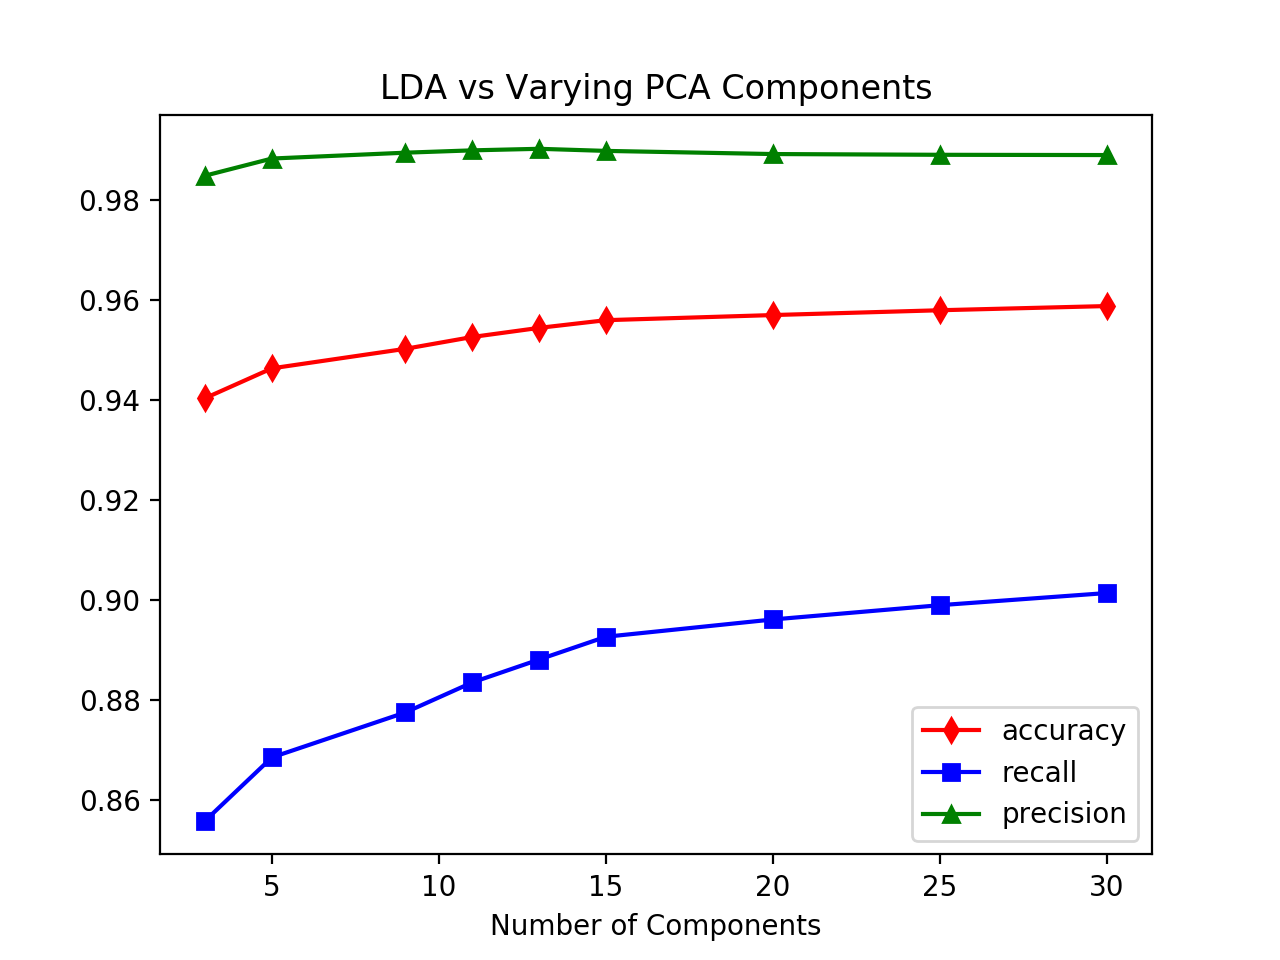

In [5]:
plt.close()
lines = plt.plot(pca_comp, pca_results['accuracy'], 'rd-', pca_comp, pca_results['recall'], 'bs-', pca_comp, pca_results['precision'], 'g^-')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower right')
plt.title('LDA vs Varying PCA Components')
plt.xlabel('Number of Components')
plt.show()

### Plot Scores - Lasso

<IPython.core.display.Javascript object>


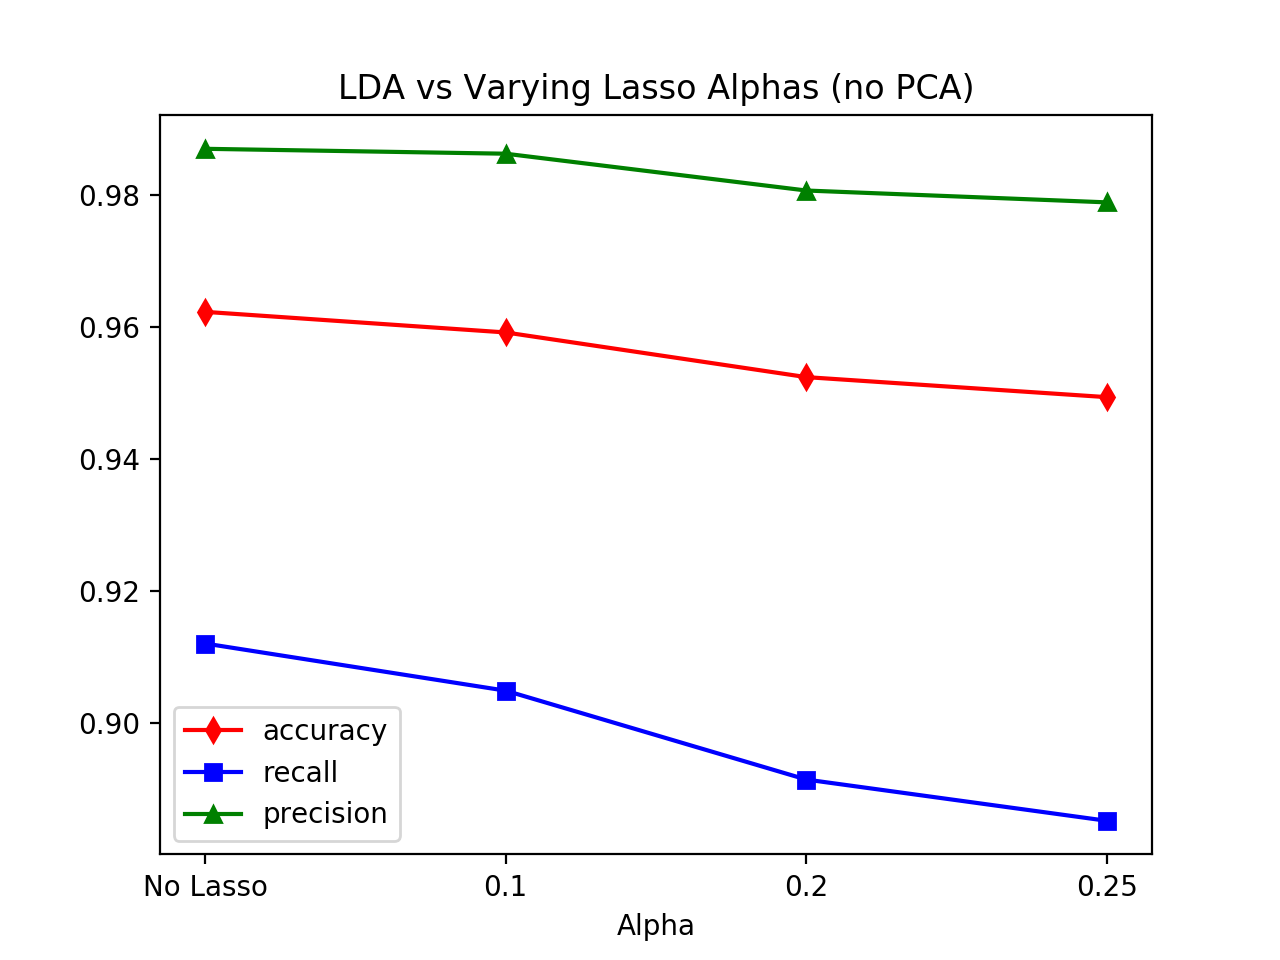

In [10]:
plt.close()
x = range(4)
x_labels = ['No Lasso', 0.1, 0.2, 0.25]
lines = plt.plot(x, lasso_results['accuracy'], 'rd-', x, lasso_results['recall'], 'bs-', x, lasso_results['precision'], 'g^-')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower left')
plt.title('LDA vs Varying Lasso Alphas (no PCA)')
plt.xlabel('Alpha')
plt.xticks(x, x_labels)

plt.show()

### Plot Scores - Lasso + PCA

<IPython.core.display.Javascript object>


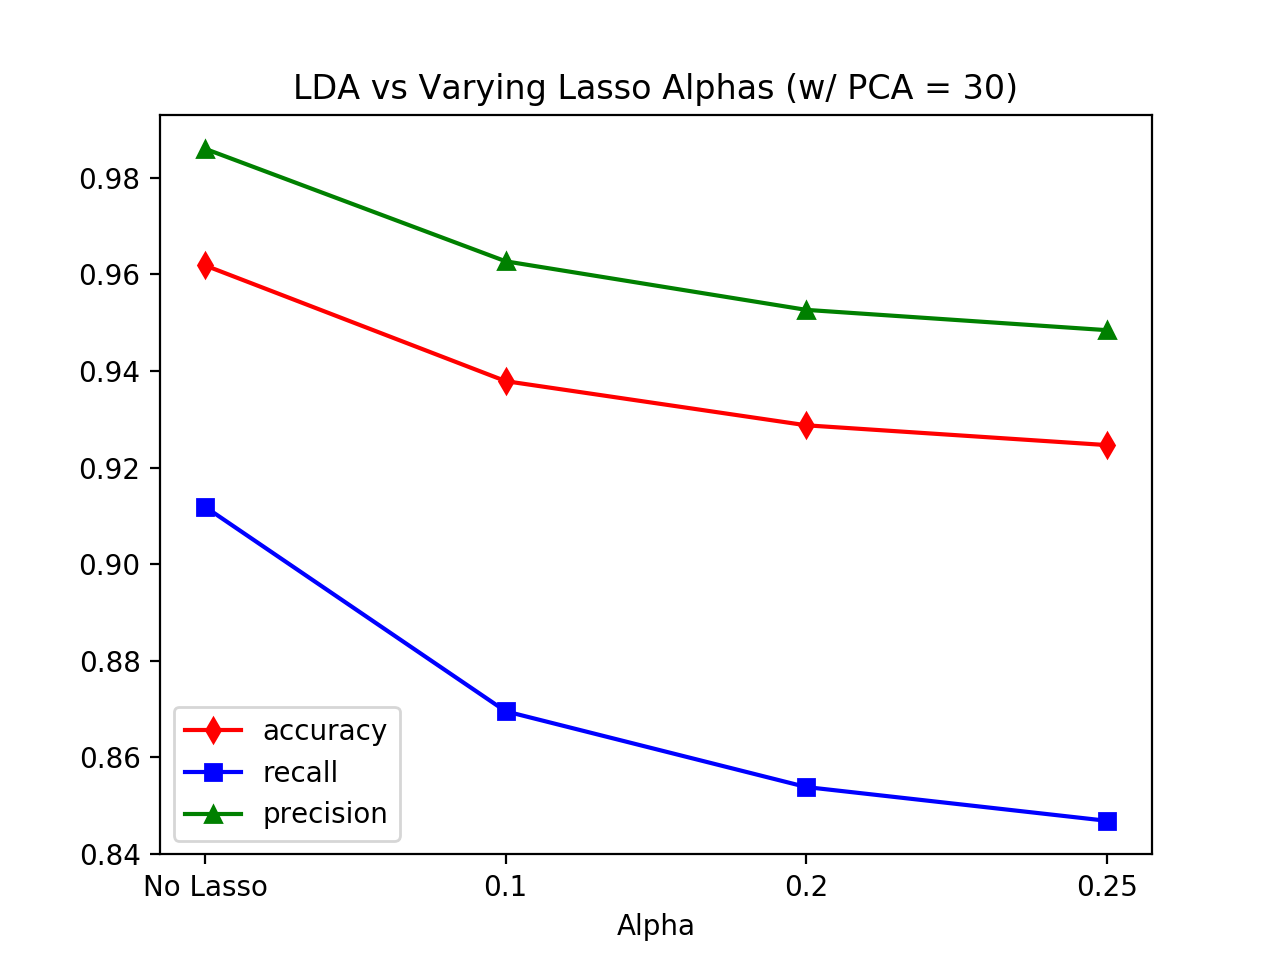

In [9]:
plt.close()
x = range(4)
x_labels = ['No Lasso', 0.1, 0.2, 0.25]
lines = plt.plot(x, lasso_results_pca['accuracy'], 'rd-', x, lasso_results_pca['recall'], 'bs-', x, lasso_results_pca['precision'], 'g^-')
plt.legend(lines, ('accuracy','recall','precision'),loc='lower left')
plt.title('LDA vs Varying Lasso Alphas (w/ PCA = 30)')
plt.xlabel('Alpha')
plt.xticks(x, x_labels)
plt.show()

In [21]:
best_pca_comp

30

## Confusion matrices

In [57]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f'%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
bsf[0]

0.95834853801169573

<IPython.core.display.Javascript object>


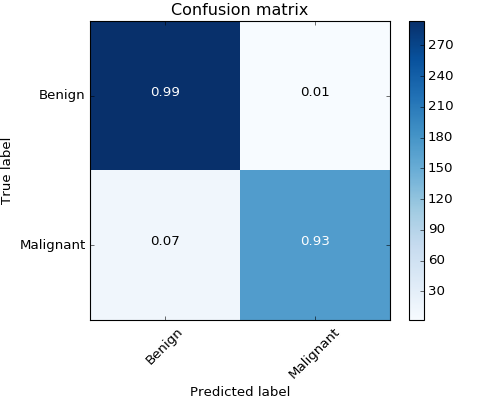

Normalized confusion matrix


In [58]:
plt.figure(figsize=(6,5))
X_reduced = my_pca(X,bsf[1])
y_pred = mdl.fit(X_reduced, y).predict(X_reduced)
cm_pca = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm_pca, classes=['Benign', 'Malignant'], normalize=True)
